In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 6c

## Multiple Hidden Layers Multi-class Output
### Fashion MNIST dataset.
</p><img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os

from datetime import datetime

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from collections.abc import Callable

from typing import Literal

from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

%matplotlib inline

In [3]:
# Some basic parameters

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models' # location to models 
dataDir = 'fashion_mnist' # location where model for this data will be stored

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results


EPOCHS = 20001 # number of cycles to run
ALPHA = 0.1 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Helper Functions

In [4]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------


def fn_plot_hist(hist_df: pd.DataFrame):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: epoch
            column 1: loss
            column 2: ts_loss
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
    
    # create figure and axis array
    fig, ax = plt.subplots(1,1 , figsize = (15,6)) 

    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    
    
    # Plot Column 0 and 2 (Loss and validation loss)
    hist_df.plot(x = hist_df.columns[0], y = [hist_df.columns[1],  hist_df.columns[2]], 
                 ax = ax,
                 colormap=CMAP) 

    # get minimum values for plotting
    lossmin = hist_df[hist_df.columns[1]].min()
    
    testmin = hist_df[hist_df.columns[2]].min()

    
    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.4, 0.95, txtstr,
            transform=ax.transAxes,
            fontsize=14,
            verticalalignment='top',
            bbox=props)

    # x axis label
    ax.set_xlabel("Epochs")

    # y axis lable
    ax.set_ylabel(hist_df.columns[1].capitalize())
    
    # Show grids on the axis
    ax.grid()
    
    plt.tight_layout()

## Load dataset
<p style="font-family: Arial; font-size:1.2em;color:black;">
We will be using Fashion MNIST dataset. The dataset can be found in the input directory.
</p>

In [5]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [6]:
labels = {'0': 'T-shirt/top',
          '1': 'Trouser',
          '2': 'Pullover',
          '3': 'Dress',
          '4': 'Coat',
          '5': 'Sandal',
          '6': 'Shirt',
          '7': 'Sneaker',
          '8': 'Bag',
          '9': 'Ankle boot'}

In [7]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


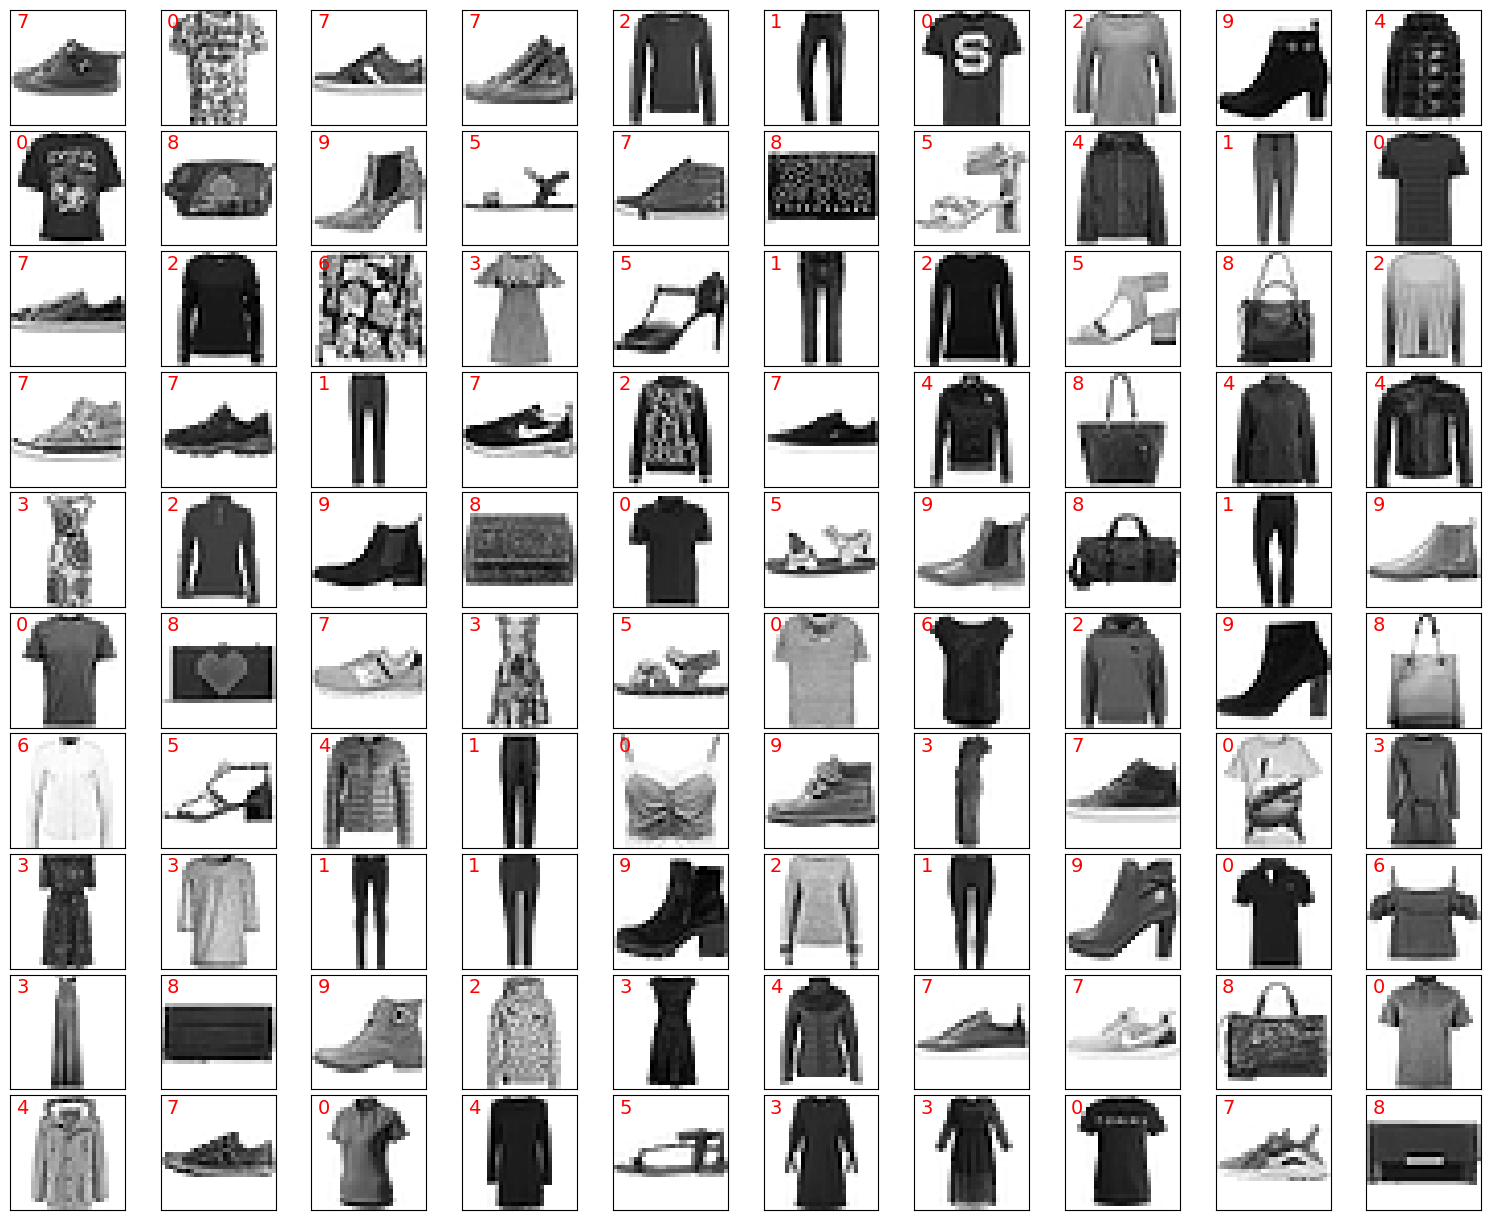

In [8]:
# Sample data plot

plot_df = train_df.sample(n = 100) # Take 100 sample from the training set

fig = plt.figure(figsize=(15, 12))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:].reshape(28,28) # reshape row to a 28x28 matrix
    
    ax = fig.add_subplot(10, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.text(1, 4, str(row.iloc[0]), color='red', fontsize=14)   # add number (class) of the image
    
plt.show()

In [9]:
train_df.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

## All labels are given in one column. lets convert them using one hot encoding

We will use OneHotEncoder from sklearn.preprocessing

In [10]:
one_hot = OneHotEncoder(sparse_output=False)
y_train = train_df[["label"]]
X_train = train_df.drop('label', axis = 1).values
y_train = one_hot.fit_transform(y_train)

y_test = test_df[["label"]]
X_test = test_df.drop('label', axis = 1).values
y_test = one_hot.transform(y_test)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

In [12]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
y_train[:5]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [14]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
y_test[:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

# Neural Network

## Recap
<img src='images/dnn_nb_s06_fig1.png' style='width: 800px' align = 'left'/>

## The math..
<img src='images/dnn_nb_s04_fig3.png' style='width: 800px'/>

## Multiple hidden layers

<p style="font-family: Arial; font-size:1.2em;color:black;"> 
    Moving over to multilayer network. Our data has <strong>two</strong> features. Hence size of input layer will also be two. The output is binary, we can code it as single column as well as double column output. Let's consider following hidden layers:</p>
<table style="font-family: Arial; font-size:1.2em;color:black;">
    <tr>
        <th>#</th>
        <th>Layer Number</th>
        <th>Nodes </th>
        <th>Activation </th>
    </tr>
    <tr>
        <td>1</td>
        <td>Input Layer</td>
        <td>2</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>2</td>
        <td>Hidden Layer 1</td>
        <td>5</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>3</td>
        <td>Hidden Layer 2</td>
        <td>5</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>4</td>
        <td>Hidden Layer 3</td>
        <td>4</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>5</td>
        <td>Hidden Layer 4</td>
        <td>3</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>6</td>
        <td>Layer 5 (Output)</td>
        <td>2</td>
        <td>softmax</td>
    </tr>
</table>

<img src='images/dnn_nb_s06_fig3.png' style='width: 800px'/>

## Activation Functions

In [16]:
def fn_softmax(z : np.ndarray) -> np.ndarray:
    
    '''
    Args:
        z : a matrix of z values of shape (m, n_output)
    returns:
        Softmax values of z
    
    '''
    
    exp_scores = np.exp( z - np.max(z) )

    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [17]:
def fn_tanh(z: np.ndarray) -> np.ndarray:
    
    '''
        Args:
           z : array, Aggregated values 
       Return:
           Activations for each z
    '''

    return np.tanh(z)

def fn_tanh_prime(a: np.ndarray) -> np.ndarray:
    '''
        Args:
           a : array, Aggregated values 
       Return:
           Derivative, for each a
    '''

    return 1.0 - np.tanh(a)**2

## Loss Function
<p style="font-family: Arial; font-size:1.2em;color:black;">
The loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:
</p>
$$
\begin{aligned}
L(\hat{y},y) =  -y.log\hat{y} - (1-y) . log(1-\hat{y})
\end{aligned}
$$
<p style="font-family: Arial; font-size:1.2em;color:black;">
For all samples:
</p>
$$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i \in m}y_i.log\hat{y_i} - (1-y_i) . log(1-\hat{y_i})
\end{aligned}
$$

In this case, our labels are one-hot-encoded hence we will use complete formula.

In [18]:
# Helper function to evaluate the total loss on the dataset

def calculate_loss(model : dict, X_l: np.ndarray, y_l: np.ndarray) -> np.float64:
    
    # Extract weights and losses from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    # number of examples
    m = X_l.shape[0]
    
    #***********************************
    # Layer 1
    z1 = X_l.dot(W1) + b1 
    a1 = np.tanh(z1)    # tanh activation
    
    # Layer 2
    z2 = a1.dot(W2) + b2 
    a2 = np.tanh(z2)    # tanh activation
    
    # Layer 3
    z3 = a2.dot(W3) + b3 
    a3 = np.tanh(z3)    # tanh activation

    # Layer 4
    z4 = a3.dot(W4) + b4 
    a4 = np.tanh(z4)    # tanh activation

    # Layer 5
    z5 = a4.dot(W5) + b5 # Aggregation
    a5 = fn_softmax(z5)  # softmax activation
    #***********************************
         
    # Calculating the loss
    # NOTE: both y as well as probs are num_sample x num_class materix
    assert (a5.shape == y_l.shape),"Shape of y_hat and y do not match"
    data_loss = - (y_l* np.log(a5) + (1 - y_l) *np.log(1 - a5)).sum()
    
    return 1./m * data_loss

## Forward Propogation

<img src='images/dnn_nb_s06_fig4.png' style='width: 800px' alt = 'Session 6 Figure 4'/>
<br>
                                                               
$
\begin{aligned}
Z^{[l]} & = A^{[l-1]} . W^{[l]} + b^{[l]}\\
A^{[l]} & = \tanh(Z^{[l]}) \\
\end{aligned}
$
<hr>
<p style="font-family: Arial; font-size:1.2em;color:black;">
    And for last layer.</p>
$
\begin{aligned}
Z^{[L]} & = A^{[L-1]} . W^{[L]} + b^{[L]} \\
A^{[L]} & = \mathrm{softmax}(Z^{[L]}) \\
\end{aligned}
$

<p style="font-family: Arial; font-size:1.2em;color:black;">
    Where:
</p>
$
\begin{aligned}
\mathrm{softmax}(z_i) & =  \frac{e^{z_i}}{\sum_{i=1}^n {e^{z_i}}}\\
\end{aligned}
$

## Predict Function
<p style="font-family: Arial; font-size:1.2em;color:black;">
For predictions, we will simply be using the forward propagation. No need to iterate or calculate the back propogation for supervised learning.
</p>

In [19]:
# Helper function to predict an output (0 or 1)

def predict(model : dict, X_p: np.ndarray) -> np.ndarray:
    '''
     Args:
         model
         x: input features
    '''
    # Extract weights and losses from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    #***********************************
    # Layer 1
    z1 = X_p.dot(W1) + b1 
    a1 = np.tanh(z1)    # tanh activation
    
    # Layer 2
    z2 = a1.dot(W2) + b2 
    a2 = np.tanh(z2)    # tanh activation
    
    # Layer 3
    z3 = a2.dot(W3) + b3 
    a3 = np.tanh(z3)    # tanh activation

    # Layer 4
    z4 = a3.dot(W4) + b4 
    a4 = np.tanh(z4)    # tanh activation

    # Layer 5
    z5 = a4.dot(W5) + b5 # Aggregation
    a5 = fn_softmax(z5)  # softmax activation
    #***********************************
    
    return np.argmax(a5, axis = 1)

<p style="font-family: Arial; font-size:1.2em;color:black;">
We can use $gradient$ $descent$ to find its minimum. For the purpose of this excercise, we will use $batch$ $gradient$ descent with a fixed learning rate. 
</p>
<p style="font-family: Arial; font-size:1.2em;color:black;">
As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: $\frac{\partial{L}}{\partial{W_l}}(= \partial{W^{[l]}})$, $\frac{\partial{L}}{\partial{b_l}}(= \partial{b^{[l]}})$, etc. To calculate these gradients we use the *backpropagation algorithm*, which is a way to efficiently calculate the gradients starting from the output.
    </p>

## Backpropogation
<hr>
<p style="font-family: Arial; font-size:1.2em;color:black;">
    For last layer.</p>
$
\begin{aligned}
\partial{Z^{[L]}}  & = A^{[L]} - y \\
\partial{W^{[L]}}  & = \frac{1}{m} A^{[L-1]T}\circ \partial{Z^{[L]}} \\
\partial{b^{[L]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{Z^{[L]}}, axis = 1, keepdims = True) \\
\end{aligned}
$
<hr>
<p style="font-family: Arial; font-size:1.2em;color:black;">
    For any other layer</p>
$
\begin{aligned}
\partial{A^{[l]}}  & = \partial{Z^{[l+1]}} . \partial{W^{[l+1]T}}\\
\partial{Z^{[l]}}  & = \partial{A^{[l]}} * ( 1-A^{[l]}**2)\\
\partial{W^{[l]}}  & = \frac{1}{m} A^{[l-1]T}\circ \partial{Z^{[l]}} \\
\partial{b^{[l]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{Z^{[l]}}, axis = 1, keepdims = True) \\
\\
\end{aligned}
$

In [20]:
# prepare the Model

def build_model(param: dict, 
                X_tr : np.ndarray, 
                y_tr: np.ndarray, 
                X_ts : np.ndarray, 
                y_ts: np.ndarray, 
                epochs : np.int64 = EPOCHS,
                alpha :np.float64 = ALPHA) -> dict:
    
    '''
        nn_hdim : Number of nodes in the hidden layer
        X_tr : Features to train on
        y_tr : Targets to train on
        epochs : Number of passes through the training data for gradient descent
        alpha : learning Rate
    '''
    # number of examples
    m = X_tr.shape[0]
    
    # Initialize the parameters to random values. We need to learn these.
    W1 = np.random.randn(param['nn_hdim'][0], param['nn_hdim'][1]) / np.sqrt(param['nn_hdim'][0])
    b1 = np.zeros((1, param['nn_hdim'][1]))
    
    W2 = np.random.randn(param['nn_hdim'][1], param['nn_hdim'][2]) / np.sqrt(param['nn_hdim'][1])
    b2 = np.zeros((1, param['nn_hdim'][2]))
    
    W3 = np.random.randn(param['nn_hdim'][2], param['nn_hdim'][3]) / np.sqrt(param['nn_hdim'][2])
    b3 = np.zeros((1, param['nn_hdim'][3]))
    
    W4 = np.random.randn(param['nn_hdim'][3], param['nn_hdim'][4]) / np.sqrt(param['nn_hdim'][3])
    b4 = np.zeros((1, param['nn_hdim'][4]))
   
    W5 = np.random.randn(param['nn_hdim'][4], nn_output_dim) / np.sqrt(param['nn_hdim'][4])
    b5 = np.zeros((1, nn_output_dim))

    # Store model parameters in a dict to retuen in the end
    model = {}
    
    assert (W1.shape == tuple(param['nn_hdim'][0:2])), 'Incorrect shape of W1 :{}'.format(W1.shape)
    
    # lists to collect losses
    curr_loss = 0
    loss = []
    t_curr_loss = 0
    t_loss = []
    epoch = []

    # It a lenghty iterations. Lets keep track of time
    startTime = datetime.now()
    print (f'Starting Iterations at {datetime.now().strftime("%d/%m/%Y %H:%M:%S")}')

    # Gradient descent. For each batch...
    for i in range(0, epochs):

        #############################
        ###  Forward propagation  ###
        #############################

        #***********************************
        # Layer 1
        z1 = X_tr.dot(W1) + b1 
        a1 = np.tanh(z1)    # tanh activation

        # Layer 2
        z2 = a1.dot(W2) + b2 
        a2 = np.tanh(z2)    # tanh activation

        # Layer 3
        z3 = a2.dot(W3) + b3 
        a3 = np.tanh(z3)    # tanh activation

        # Layer 4
        z4 = a3.dot(W4) + b4 
        a4 = np.tanh(z4)    # tanh activation

        # Layer 5
        z5 = a4.dot(W5) + b5 # Aggregation
        a5 = fn_softmax(z5)  # softmax activation
        #***********************************


        #########################
        #### Backpropagation #### 
        #########################
        
        # Layer 5 **********************************
        # dL/db = dL/dz = (a-y). 
        dz5 = a5 -y_tr # shape = 1024, 2
        
        dw5 = (a4.T).dot(dz5)
        assert (dw5.shape == W5.shape),"Shape of dw5 {} and W5 {} do not match".format(dw5.shape, W5.shape)
        
        db5 = np.sum(dz5, axis=0, keepdims=True)  # db5 is vertical sum of dz5
        assert (db5.shape == b5.shape),"Shape of db5 {} and b5 {} do not match".format(db5.shape, b5.shape)
        
        da4 = dz5.dot(W5.T)
        assert (da4.shape == a4.shape),"Shape of da4 {} and a4 {} do not match".format(da4.shape, a4.shape)
        
        # Layer 4 **********************************
        dz4 = da4 * (1 - np.power(a4, 2))
        assert (dz4.shape == z4.shape),"Shape of dz4 {} and z4{} do not match".format(dz4.shape, z4.shape)
        
        dw4 = (a3.T).dot(dz4)
        assert (dw4.shape == W4.shape),"Shape of dw4 {} and W4 {} do not match".format(dw4.shape, W4.shape)
        
        db4 = np.sum(dz4, axis=0, keepdims=True)
        assert (db4.shape == b4.shape),"Shape of db4 {} and b4 {} do not match".format(db4.shape, b4.shape)
        
        da3= dz4.dot(W4.T)
        assert (da3.shape == a3.shape),"Shape of da3 {} and a3 {} do not match".format(da3.shape, a3.shape)

        # Layer 3 **********************************
        dz3 = da3 * (1 - np.power(a3, 2))
        assert (dz3.shape == z3.shape),"Shape of dz3 {} and z3{} do not match".format(dz3.shape, z3.shape)
        
        dw3 = (a2.T).dot(dz3)
        assert (dw3.shape == W3.shape),"Shape of dw3 {} and W3 {} do not match".format(dw3.shape, W3.shape)
        
        db3 = np.sum(dz3, axis=0, keepdims=True)
        assert (db3.shape == b3.shape),"Shape of db3 {} and b3 {} do not match".format(db3.shape, b3.shape)
        
        da2= dz3.dot(W3.T)
        assert (da2.shape == a2.shape),"Shape of da2 {} and a2 {} do not match".format(da2.shape, a2.shape)

        # Layer 2 **********************************
        dz2 = da2 * (1 - np.power(a2, 2))
        assert (dz2.shape == z2.shape),"Shape of dZ2 {} and Z2{} do not match".format(dz2.shape, z2.shape)
        
        dw2 = (a1.T).dot(dz2)
        assert (dw2.shape == W2.shape),"Shape of dw2 {} and W2 {} do not match".format(dw2.shape, W2.shape)
        
        db2 = np.sum(dz2, axis=0, keepdims=True) 
        assert (db2.shape == b2.shape),"Shape of db2 {} and b2 {} do not match".format(db2.shape, b2.shape)
        
        da1= dz2.dot(W2.T)
        assert (da1.shape == a1.shape),"Shape of da1 {} and a1 {} do not match".format(da1.shape, a1.shape)

        # Layer 1 **********************************
        dz1 = da1 * (1 - np.power(a1, 2))
        assert (dz1.shape == z1.shape),"Shape of dz1 {} and z1{} do not match".format(dz1.shape, z1.shape)
        
        dw1 = (X_tr.T).dot(dz1)
        assert (dw1.shape == W1.shape),"Shape of dw1 {} and W1 {} do not match".format(dw1.shape, W1.shape)
        
        db1 = np.sum(dz1, axis=0, keepdims=True) 
        assert (db1.shape == b1.shape),"Shape of db1 {} and b1 {} do not match".format(db1.shape, b1.shape)
        #dA0= dZ1.dot(W1.T)
        #assert (dA1.shape == A1.shape),"Shape of dA1 {} and A1 {} do not match".format(dA1.shape, A1.shape)


        # Gradient descent parameter update
        W1 += -alpha * dw1 /m
        b1 += -alpha * db1 /m
        
        W2 += -alpha * dw2 /m
        b2 += -alpha * db2 /m
        
        W3 += -alpha * dw3 /m
        b3 += -alpha * db3 /m
        
        W4 += -alpha * dw4 /m
        b4 += -alpha * db4 /m
        
        W5 += -alpha * dw5 /m
        b5 += -alpha * db5 /m
        
        # Assign new parameters to the model
        model = { 
            'W1': W1, 'b1': b1,
            'W2': W2, 'b2': b2,
            'W3': W3, 'b3': b3,
            'W4': W4, 'b4': b4,
            'W5': W5, 'b5': b5}
        
        
        if i % 10 == 0 :
            
            epoch.append(i)
            
            curr_loss = calculate_loss(model, X_tr, y_tr)
            loss.append(curr_loss)
            
            t_curr_loss = calculate_loss(model, X_ts, y_ts)
            t_loss.append(t_curr_loss)
            
            
        # Print the loss.
        if i % 1000 == 0:
            elapsedTime = datetime.now()
            print (f'Iteration {i}: Elapsed time-{elapsedTime-startTime}, Loss {curr_loss : .3f}')
    
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    loss_hist['test_loss'] = t_loss
    
    return model

In [21]:
# define nodes in each of dims
layer_param = {}

loss_hist = {}

# First layer same as number of features and thereafter 20,20,10,10,10
layer_param['nn_hdim'] = [X_train.shape[1],30,25,20,15,10] 


In [22]:
nn_output_dim = y_train.shape[1] # output layer dimensionality

# Build a model with a 4-dimensional hidden layer
model = build_model(layer_param, X_train, y_train, X_test, y_test)

Starting Iterations at 16/11/2023 10:18:23
Iteration 0: Elapsed time-0:00:00.863500, Loss  3.239
Iteration 1000: Elapsed time-0:09:25.544797, Loss  0.751
Iteration 2000: Elapsed time-0:18:51.370746, Loss  0.670
Iteration 3000: Elapsed time-0:28:14.766724, Loss  0.625
Iteration 4000: Elapsed time-0:37:37.972596, Loss  0.584
Iteration 5000: Elapsed time-0:47:01.385702, Loss  0.591
Iteration 6000: Elapsed time-0:56:26.035652, Loss  0.582
Iteration 7000: Elapsed time-1:05:55.871716, Loss  0.541
Iteration 8000: Elapsed time-1:15:17.729091, Loss  0.527
Iteration 9000: Elapsed time-1:24:40.961304, Loss  0.545
Iteration 10000: Elapsed time-1:34:04.493941, Loss  0.515
Iteration 11000: Elapsed time-1:43:28.009342, Loss  0.517
Iteration 12000: Elapsed time-1:52:51.364906, Loss  0.517
Iteration 13000: Elapsed time-2:02:15.995889, Loss  0.519
Iteration 14000: Elapsed time-2:11:39.183719, Loss  0.461
Iteration 15000: Elapsed time-2:21:02.193480, Loss  0.479
Iteration 16000: Elapsed time-2:30:26.9546

## Saving Model
Our model is a dictionary objects with learned parameters. 

In [23]:
import pickle

modelFilename = 'multi_layer_fashion_mnist.pkl'
modelPath = os.path.join(modelDir, dataDir, modelFilename)

with open(modelPath, 'wb') as file:
    pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

with open(modelPath, 'rb') as handle:
    model1 = pickle.load(handle)

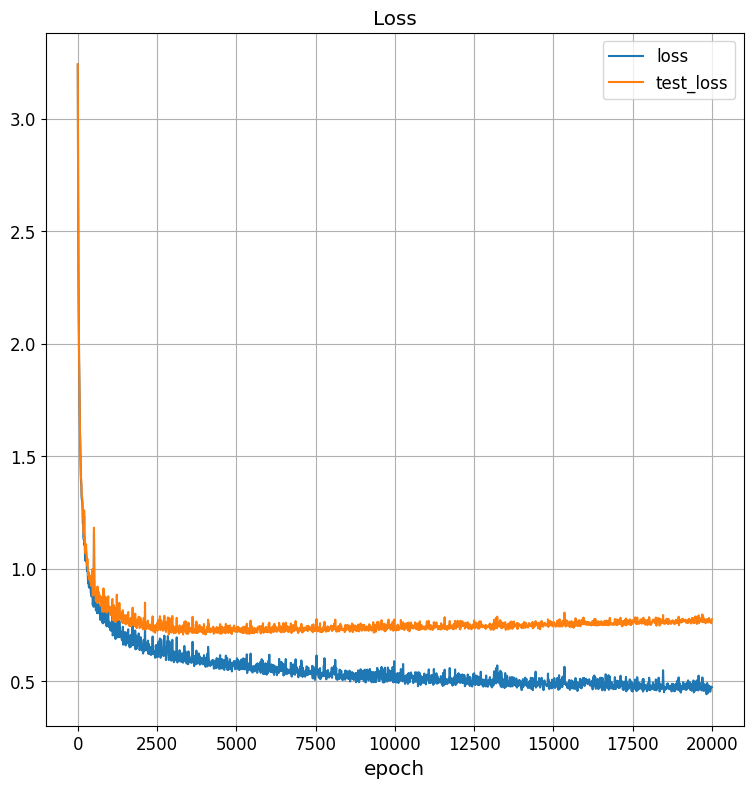

In [24]:
loss_df = pd.DataFrame(loss_hist)
ax = loss_df.plot(x = 'epoch')
ax.grid()
ax.set_title('Loss');

In [36]:
loss_df[loss_df.test_loss==loss_df.test_loss.min()]

,epoch,loss,test_loss
403,4030,0.564565,0.707657


In [38]:
y_pred.shape

(10000,)

In [39]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_train)

print('Accruacy score on Train Data :', accuracy_score(y_train.argmax(axis = 1), y_pred))

Accruacy score on Train Data : 0.9050333333333334


In [40]:
cm_train = confusion_matrix(y_train.argmax(axis = 1), y_pred)

In [41]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_test)

print('Accruacy score on Test Data :', accuracy_score(y_test.argmax(axis = 1), y_pred))

Accruacy score on Test Data : 0.8563


In [42]:
cm_test = confusion_matrix(y_test.argmax(axis = 1), y_pred)

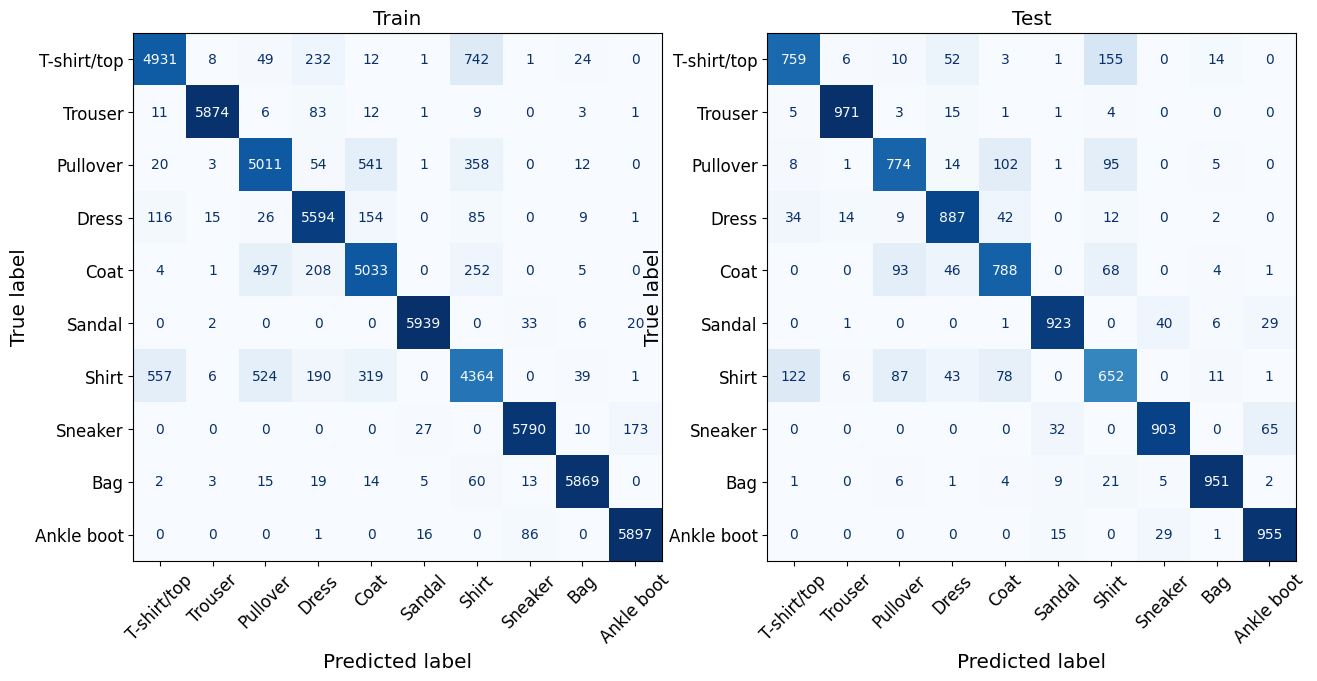

In [45]:
fig, axes = plt.subplots(1,2, figsize = (15,8) )

ax = axes[0]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=labels.values())
disp.plot(ax = ax, cmap = 'Blues', colorbar=False, xticks_rotation=45.)
ax.set_title('Train')

ax = axes[1]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=labels.values())
disp.plot(ax = ax, cmap = 'Blues', colorbar=False, xticks_rotation=45.)

ax.set_title('Test')

plt.show();

In [46]:
plot_df = test_df[test_df['label'] != test_df['pred']]
plot_df.shape

(1437, 786)

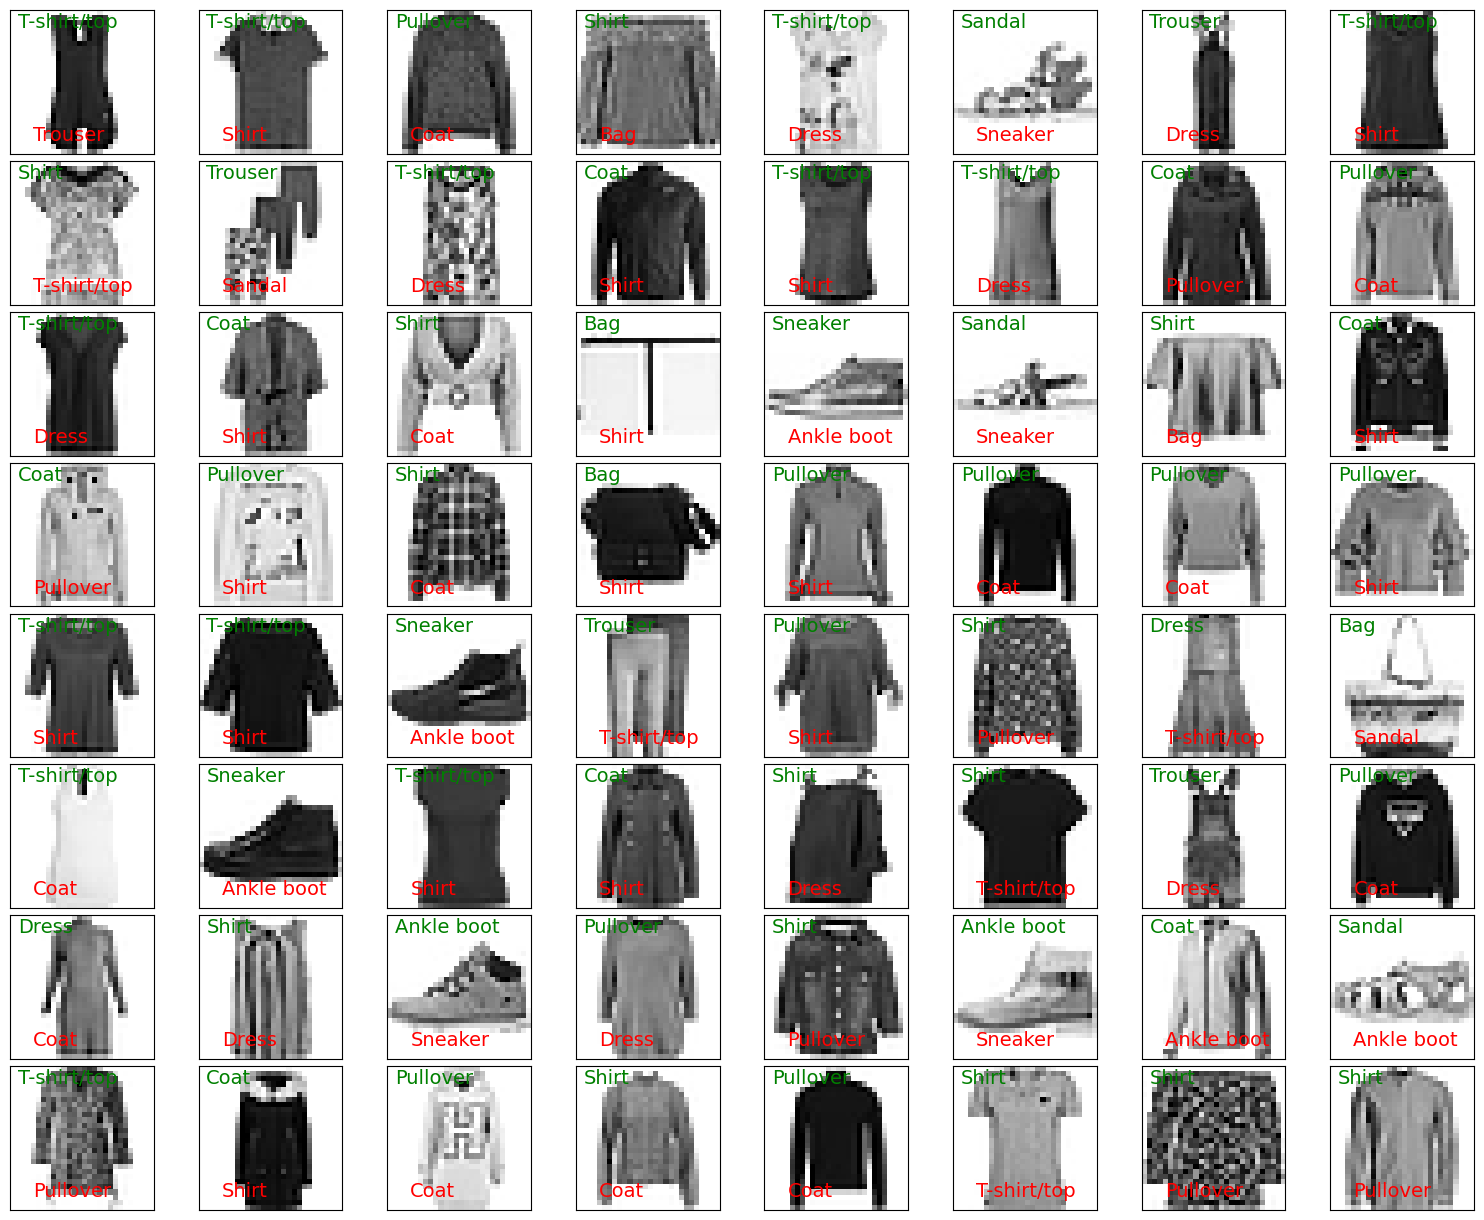

In [48]:
# lets see samples where it could not predict properly
# Sample data plot

plot_df = plot_df.sample(n = 64) # Take 64 sample from the training set

fig = plt.figure(figsize=(15, 12))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:-1].reshape(28,28) # reshape row to a 28x28 matrix
    
    ax = fig.add_subplot(8, 8, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.text(1, 3, labels[str(row.iloc[0])], color='green', fontsize=14)   # add number (class) of the image
    ax.text(4, 25, labels[str(row.iloc[-1])], color='red', fontsize=14)   # add number (class) of the image
    
plt.show()